In [1]:
# Import libraries
import torch
import torch.nn as nn
import pytorch_lightning as pl
import numpy as np
import time
import scipy.io
import pandas as pd
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
%matplotlib inline
import scienceplots
from DeepFlow import *
import warnings
warnings.filterwarnings('ignore')

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
torch.manual_seed(123456)
np.random.seed(123456)
device = torch.device('cuda:0')

In [3]:
# Generate Neural Network
class DNN(pl.LightningModule):

    def __init__(self):
        super(DNN, self).__init__()
        self.net = nn.Sequential()                                                  # Define neural network
        self.net.add_module('Linear_layer_1', nn.Linear(2, 30))                     # First linear layer
        self.net.add_module('Tanh_layer_1', nn.Tanh())                              # First activation Layer

        for num in range(2, 7):                                                     # Number of layers (2 through 7)
            self.net.add_module('Linear_layer_%d' % (num), nn.Linear(30, 30))       # Linear layer
            self.net.add_module('Tanh_layer_%d' % (num), nn.Tanh())                 # Activation Layer
        self.net.add_module('Linear_layer_final', nn.Linear(30, 4))                 # Output Layer

    # Forward Feed
    def forward(self, x):
        return self.net(x)

    # Loss function for PDE
    def loss_FVM(self, x, q ,nx,ny,idf):
        y = self.net(x)
        
        q_1 = torch.tensor(q[1:ny-1,1:nx-1,0].flatten()[:, None],dtype=torch.float32).to(device)
        q_2 = torch.tensor(q[1:ny-1,1:nx-1,1].flatten()[:, None], dtype=torch.float32).to(device)
        q_3 = torch.tensor(q[1:ny-1,1:nx-1,2].flatten()[:, None], dtype=torch.float32).to(device)
        q_4 = torch.tensor(q[1:ny-1,1:nx-1,3].flatten()[:, None], dtype=torch.float32).to(device)
        
        f = (((y[:,0:1] - q_1))**2).mean() + (((y[:,1:2] - q_2/q_1))**2).mean() + (((y[:,2:3] - q_3/q_1))**2).mean() + (((y[:,3:] - q_4/q_1))**2).mean()
        
        return f


In [4]:
# Convert torch tensor into np.array
def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or ' \
                        'np.ndarray, but got {}'.format(type(input)))

In [5]:
def Euler_IC(x,y,IC):
    if IC == 1:
        
        p = [1.0,  0.4,     0.0439,  0.15  ];
        r = [1.0,  0.5197,  0.1072,  0.2579];
        u = [0.0, -0.7259, -0.7259,  0.0   ];
        v = [0.0, -0.0,    -1.4045, -1.4045];
        
    if IC == 2:
        
        p = [1.0,  0.4,     1.0,     0.4   ];
        r = [1.0,  0.5197,  1.0,     0.5197];
        u = [0.0, -0.7259, -0.7259,  0.0   ];
        v = [0.0,  0.0,    -0.7259, -0.7259];
        
    if IC == 3:
        
        p = [1.5, 0.3,    0.029, 0.3   ];
        r = [1.5, 0.5323, 0.138, 0.5323];
        u = [0.0, 1.206,  1.206, 0.0   ];
        v = [0.0, 0.0,    1.206, 1.206 ];
        
    if IC == 4:
        
        p = [1.1, 0.35,   1.1,    0.35  ];
        r = [1.1, 0.5065, 1.1,    0.5065];
        u = [0.0, 0.8939, 0.8939, 0.0   ];
        v = [0.0, 0.0,    0.8939, 0.8939];
    
    if IC == 5:
        
        p = [ 1.0,   1.0,   1.0,   1.0 ];
        r = [ 1.0,   2.0,   1.0,   3.0 ];
        u = [-0.75, -0.75,  0.75,  0.75];
        v = [-0.5,   0.5,   0.5,  -0.5 ];
        
    if IC == 6:
        
        p = [ 1.0,  1.0,   1.0,   1.0 ];
        r = [ 1.0,  2.0,   1.0,   3.0 ];
        u = [ 0.75, 0.75, -0.75, -0.75];
        v = [-0.5,  0.5,   0.5,  -0.5 ];
        
    if IC == 7:
        
        p = [1.0,  0.4,    0.4,  0.4   ];
        r = [1.0,  0.5197, 0.8,  0.5197];
        u = [0.1, -0.6259, 0.1,  0.1   ];
        v = [0.1,  0.1,    0.1, -0.6259];

    if IC ==8:
        
        p = [0.4 ,    1.0,    1.0,  1.0   ];
        r = [0.5197,  1.0,    0.8,  1.0   ];
        u = [0.1,    -0.6259, 0.1,  0.1   ];
        v = [0.1,     0.1,    0.1, -0.6259];
        
    if IC ==9:
        
        p = [1.0,  1.0,  0.4,     0.4   ];
        r = [1.0,  2.0,  1.039,   0.5197];
        u = [0.0,  0.0,  0.0,     0.0   ];
        v = [0.3, -0.3, -0.8133, -0.4259];
        
    if IC ==10:
        
        p = [1.0,    1.0,     0.3333,  0.3333];
        r = [1.0,    0.5,     0.2281,  0.4562];
        u = [0.0,    0.0,     0.0 ,    0.0   ];
        v = [0.4297, 0.6076, -0.6076, -0.4297];
        
    if IC ==11:
        
        p = [1.0, 0.4,    0.4, 0.4   ];
        r = [1.0, 0.5313, 0.8, 0.5313];
        u = [0.1, 0.8276, 0.1, 0.1   ];
        v = [0.0, 0.0,    0.0, 0.7276];
        
    if IC ==12:
        
        p = [0.4,    1.0,    1.0, 1.0  ];
        r = [0.5313, 1.0 ,   0.8, 1.0  ];
        u = [0.0,    0.7276, 0.0, 0.0  ];
        v = [0.0,    0.0,    0.0, 0.7276];
        
    if IC ==13:
        
        p = [ 1.0, 1.0, 0.4,    0.4   ];
        r = [ 1.0, 2.0, 1.0625, 0.5313];
        u = [ 0.0, 0.0, 0.0 ,   0.0   ];
        v = [-0.3, 0.3, 0.8145, 0.4276];
        
    if IC ==14:
        
        p = [ 8.0,     8.0,    2.6667, 2.6667];
        r = [ 2.0,     1.0,    0.4736, 0.9474];
        u = [ 0.0,     0.0,    0.0,    0.0   ];
        v = [-0.5606, -1.2172, 1.2172, 1.1606];
        
    if IC ==15:
        
        p = [ 1.0,  0.4,     0.4, 0.4   ];
        r = [ 1.0,  0.5197,  0.8, 0.5313];
        u = [ 0.1, -0.6259,  0.1, 0.1   ];
        v = [-0.3, -0.3,    -0.3, 0.4276];
        
    if IC ==16:
        
        p = [0.4,     1.0,    1.0, 1.0  ];
        r = [0.5313,  1.0222, 0.8, 1.0  ];
        u = [0.1,    -0.6179, 0.1, 0.1  ];
        v = [0.1,     0.1,    0.1, 0.8276];
        
    if IC ==17:
        
        p = [ 1.0,  1.0, 0.4,     0.4   ];
        r = [ 1.0,  2.0, 1.0625,  0.5197];
        u = [ 0.0,  0.0, 0.0 ,    0.0   ];
        v = [-0.4, -0.3, 0.2145, -1.1259];
        
    if IC ==18:
        
        p = [1.0,  1.0, 0.4,    0.4   ];
        r = [1.0,  2.0, 1.0625, 0.5197];
        u = [0.0,  0.0, 0.0,    0.0   ];
        v = [1.0, -0.3, 0.2145, 0.2741];
        
    if IC ==19:
        
        p = [1.0,  1.0, 0.4,     0.4   ];
        r = [1.0,  2.0, 1.0625,  0.5197];
        u = [0.0,  0.0, 0.0,     0.0   ];
        v = [0.3, -0.3, 0.2145, -0.4259];
        
    r0,u0,v0,p0 = np.zeros((len(y),len(x))),np.zeros((len(y),len(x))),np.zeros((len(y),len(x))),np.zeros((len(y),len(x)))

    reg1 = np.where((x >= 0.5) & (0.5 <= y))
    reg2 = np.where((x<0.5) & (0.5<=y))
    reg3 = np.where((x < 0.5) & (y <0.5))
    reg4 = np.where((x >= 0.5) & (y<=0.5))

    r0[reg1], r0[reg2], r0[reg3], r0[reg4]  =  r[0], r[1], r[2], r[3]
    u0[reg1],u0[reg2], u0[reg3], u0[reg4]  =  u[0], u[1], u[2], u[3]
    v0[reg1], v0[reg2], v0[reg3], v0[reg4] =  v[0], v[1], v[2], v[3]
    p0[reg1],p0[reg2], p0[reg3], p0[reg4]  =  p[0], p[1], p[2], p[3]

    return r0, u0, v0, p0


In [6]:
CFL     = 0.5       #CFL number
tEnd    = 0.3       #Final time
nx      = 150       #Number of cells/Elements in x
ny      = 150       #Number of cells/Elements in y
n       = 5         #Degrees of freedom: ideal air=5, monoatomic gas=3
IC      = 3
fluxMth ='HLLE'	   
limiter ='MC'      

gamma = 1.4

Lx = 1
dx = Lx/nx
xc = np.arange(dx/2,Lx, dx)

Ly = 1
dy = Ly/ny
yc = np.arange(dy/2,Ly, dy)

x,y = np.meshgrid(xc,yc)

r0,u0,v0,p0 = Euler_IC(x,y,IC)


E0 = p0/((gamma-1)*r0)+0.5*(u0**2 + v0**2)
c0 = np.sqrt(gamma*p0/r0)
Q0 = np.zeros((ny,nx,4))

Q0[:,:,0] = r0
Q0[:,:,1] = r0*u0
Q0[:,:,2] =  r0*v0
Q0[:,:,3] = r0*E0

nx += 2
ny += 2

q0 = np.zeros((ny,nx,4))
q0[1:ny-1,1:nx-1,0:4] = Q0

q0[:,0,:] = q0[:,1,:]
q0[:,nx-1,:] = q0[:,nx-2,:]

q0[0,:,:] = q0[1,:,:]
q0[ny-1,:,:] = q0[ny-1,:,:]

vn = np.sqrt(u0**2+v0**2)
lambda1=vn+c0
lambda2=vn-c0
a0  = np.max(np.abs([lambda1, lambda2]))
dt0 = 0.0011

q=q0
t=dt0
it=0
dt=0.0011
a=a0

Y = y.flatten()[:, None]                                          # Vectorized y_grid
X = x.flatten()[:, None]                                          # Vectorized x_grid

# Sample grid (Batch training)
num_f_train = 11000
id_f = np.random.choice((nx-2)*(ny-2), num_f_train, replace=False) 


X_test = X[:, 0][:, None]                                            
Y_test = Y[:, 0][:, None]                                            
X_int = X[:, 0][:, None]                                            
Y_int = Y[:, 0][:, None]                                               

x_int_train = np.hstack((X_int, Y_int))                              
x_test = np.hstack((X_test, Y_test))

x_int_train = torch.tensor(x_int_train, requires_grad=True, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, requires_grad=True, dtype=torch.float32).to(device)

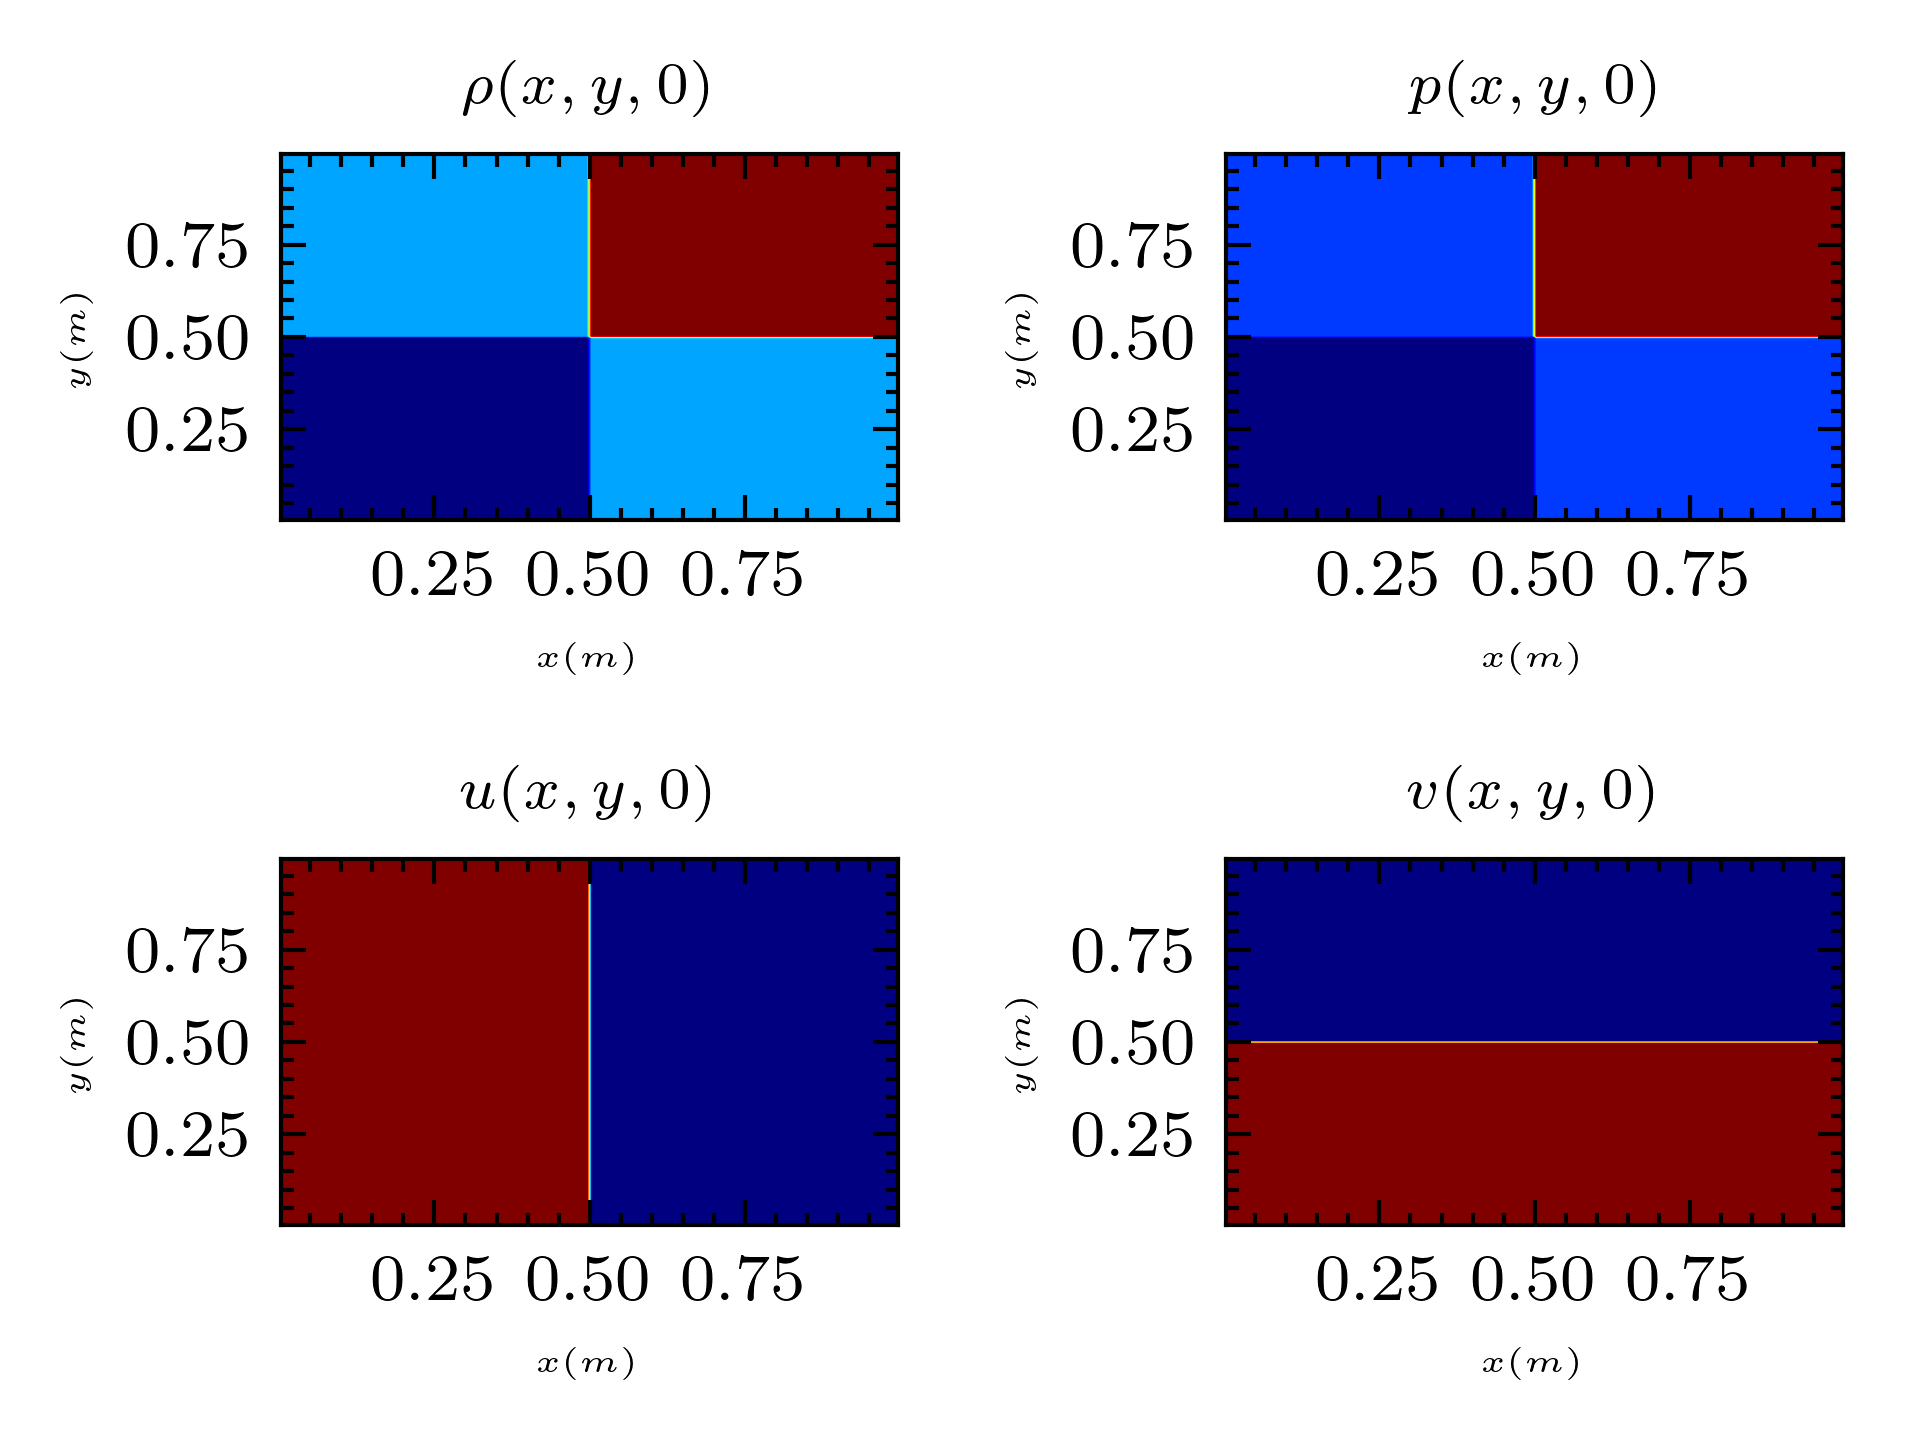

In [7]:
with plt.style.context(['science','ieee']):
    fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(nrows=2, ncols=2)
    ax1.contourf(x, y, r0,100, cmap='jet',extend='both')
    ax2.contourf(x, y, p0,100,cmap='jet',extend='both')
    ax3.contourf(x, y, u0,100,cmap='jet',extend='both')
    ax4.contourf(x, y, v0,100,cmap='jet',extend='both')


    ax1.set_xlabel(r'$x(m)$', fontsize=4)
    ax1.set_ylabel(r'$y(m)$', fontsize=4)
    ax1.set_title(r'$\rho(x,y,0)$', fontsize=7)

    ax2.set_xlabel(r'$x(m)$', fontsize=4)
    ax2.set_ylabel(r'$y(m)$', fontsize=4)
    ax2.set_title(r'$p(x,y,0)$', fontsize=7)

    ax3.set_xlabel(r'$x(m)$', fontsize=4)
    ax3.set_ylabel(r'$y(m)$', fontsize=4)
    ax3.set_title('$u(x,y,0)$', fontsize=7)

    ax4.set_xlabel(r'$x(m)$', fontsize=4)
    ax4.set_ylabel(r'$y(m)$', fontsize=4)
    ax4.set_title(r'$v(x,y,0)$', fontsize=7)
plt.tight_layout()
plt.show()

In [8]:
tic_total = time.time()
while (t < tEnd):
    DF = autodiff()
    DF_nn = DF.MUSCL_Euler_2D(q, a, gamma, dx, dy, nx, ny, limiter, fluxMth)
    f = q - dt*DF_nn

    print('.....................................')
    print('Time iteration: %d' % it)
    print('Start training t = %f' % t)
      
          
    model = DNN().to(device)
    # Loss and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
    # Train PINNs
    def train(epoch):
        model.train()
        def closure():
            optimizer.zero_grad()
            l1_norm = sum(torch.linalg.norm(p, 1) for p in model.parameters())
            loss_FVM = model.loss_FVM(x_int_train, f, nx,ny,id_f) + 1e-6*l1_norm
            loss = loss_FVM
            loss.backward()
            return loss

        # Optimize loss function
        loss = optimizer.step(closure)
        loss_value = loss.item() if not isinstance(loss, float) else loss
        
        #if epoch % 10000 == 0:
          # print(f'Epoch {epoch}: Loss: {loss_value:.8f}')
            
        return loss_value
        
    tic = time.time()
    #epoch = 0
    epochs= 20000
    #loss_value = np.inf

    for epoch in range(0,epochs+1):
        loss_value = train(epoch)
        #epoch += 1
                       
    toc = time.time()
    total_time = toc - tic
    print(f'Total loss: {loss_value:.8f}')
    print('Total training time (secs): %f' % (total_time))
        
    q_nn = to_numpy(model(x_test))  
    q_nn = pd.DataFrame(q_nn).interpolate()
    q_nn = np.reshape(q_nn.to_numpy(),(ny-2,nx-2,4))
            
    q = np.zeros((ny, nx,4))
    q[1:ny - 1, 1:nx - 1,:] = q_nn
    
    q[:, :, 1] = q[:, :, 1]*q[:, :, 0]
    q[:, :, 2] = q[:, :, 2]*q[:, :, 0]
    q[:, :, 3] = q[:, :, 3]*q[:, :, 0]
    
    q[:, 0,:]=q[:, 1,:]
    q[:, nx-1,:]=q[:, nx - 2,:]

    q[0,:,:] = q[1,:,:]
    q[ny-1,:,:] = q[ny - 2,:,:]
            
    r = q[:, :, 0]
    u = q[:, :, 1]/r
    v = q[:, :, 2]/r
    E = q[:, :, 3]/r
        
    p = (gamma - 1) * r * (E - 0.5 * (u ** 2 + v ** 2))
    c = np.sqrt(np.abs(gamma * p / r))

    vn = np.sqrt(np.abs(u ** 2 + v ** 2));
    lambda1 = vn + c
    lambda2 = vn - c
    a = np.max(np.abs([lambda1, lambda2]))

    t = t + dt
    it = it + 1 
       
tic_total_final = time.time() - tic_total
print('.....................................')
print('Total training time (secs): ', tic_total_final)
q=q[1:ny-1,1:nx-1,0:4]
r=q[:,:,0]
u=q[:,:,1]/r
v=q[:,:,2]/r
E=q[:,:,3]/r
p=(gamma-1)*r*(E-0.5*(u**2+v**2))

.....................................
Time iteration: 0
Start training t = 0.001100
Total loss: 0.00007326
Total training time (secs): 84.474192
.....................................
Time iteration: 1
Start training t = 0.002200
Total loss: 0.00007178
Total training time (secs): 81.558573
.....................................
Time iteration: 2
Start training t = 0.003300
Total loss: 0.00007829
Total training time (secs): 85.818507
.....................................
Time iteration: 3
Start training t = 0.004400
Total loss: 0.00007552
Total training time (secs): 86.071660
.....................................
Time iteration: 4
Start training t = 0.005500
Total loss: 0.00006953
Total training time (secs): 86.803466
.....................................
Time iteration: 5
Start training t = 0.006600
Total loss: 0.00007804
Total training time (secs): 91.246320
.....................................
Time iteration: 6
Start training t = 0.007700
Total loss: 0.00006868
Total training time (se

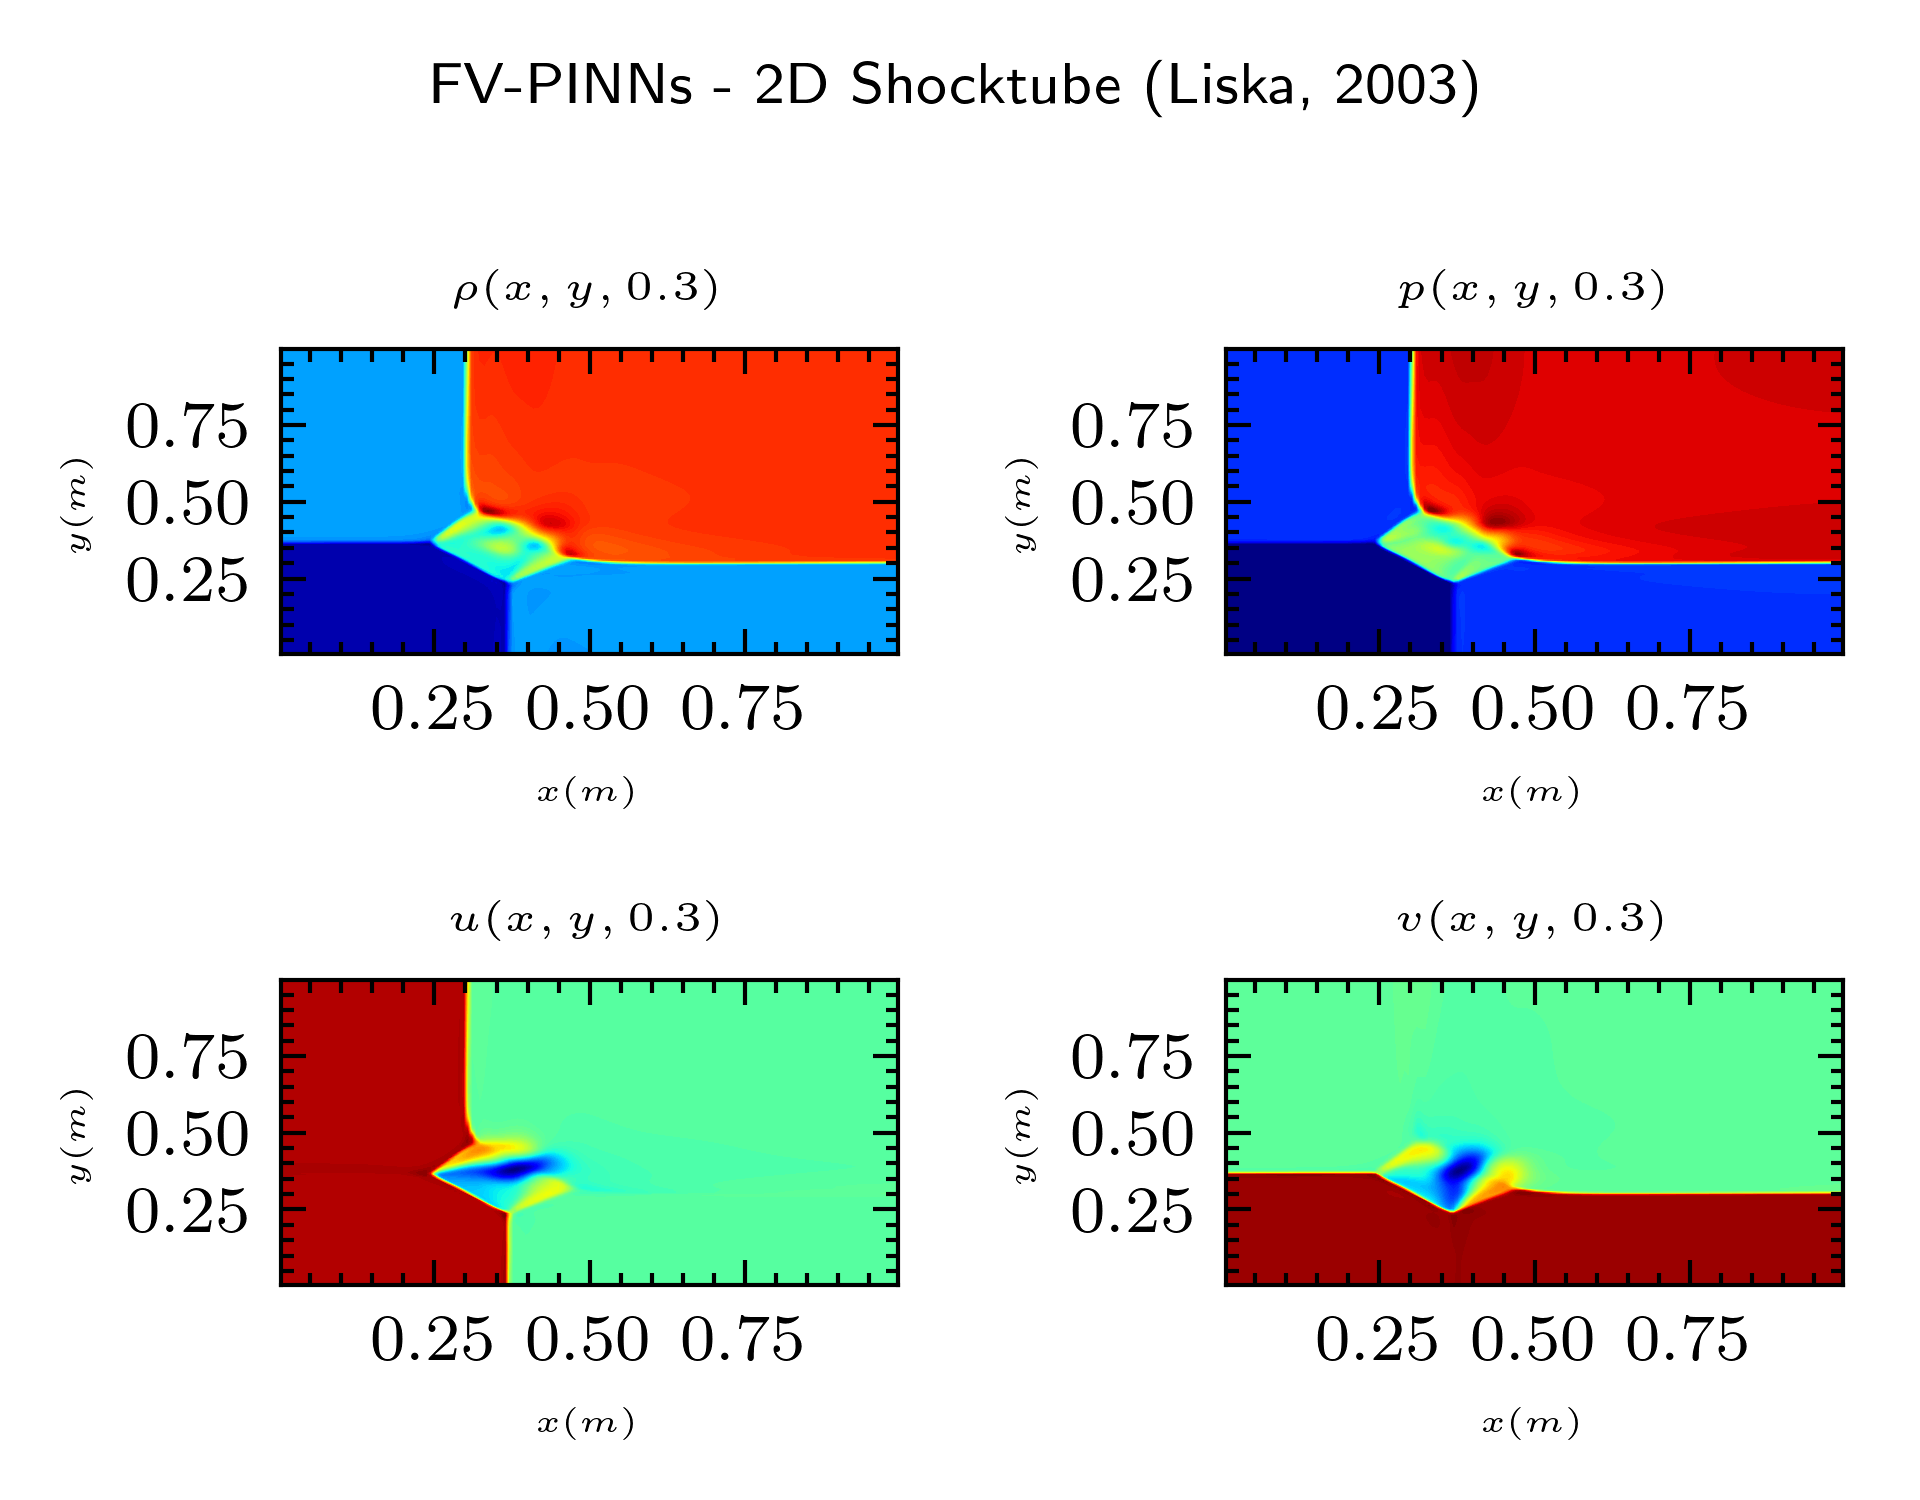

In [10]:
with plt.style.context(['science','ieee']):
    fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(nrows=2, ncols=2)
    ax1.contourf(x, y, r, 100,cmap='jet')
    ax2.contourf(x, y, p, 100,cmap='jet',extend='both')
    ax3.contourf(x, y, u, 100,cmap='jet',extend='both')
    ax4.contourf(x, y, v, 100,cmap='jet',extend='both')


    ax1.set_xlabel(r'$x(m)$', fontsize=4)
    ax1.set_ylabel(r'$y(m)$', fontsize=4)
    ax1.set_title(r'$\rho(x,y,0.3)$', fontsize=5)

    ax2.set_xlabel(r'$x(m)$', fontsize=4)
    ax2.set_ylabel(r'$y(m)$', fontsize=4)
    ax2.set_title(r'$p(x,y,0.3)$', fontsize=5)

    ax3.set_xlabel(r'$x(m)$', fontsize=4)
    ax3.set_ylabel(r'$y(m)$', fontsize=4)
    ax3.set_title(r'$u(x,y,0.3)$', fontsize=5)

    ax4.set_xlabel(r'$x(m)$', fontsize=4)
    ax4.set_ylabel(r'$y(m)$', fontsize=4)
    ax4.set_title(r'$v(x,y,0.3)$', fontsize=5)
fig.suptitle(r'FV-PINNs - 2D Shocktube (Liska, 2003)', fontsize=7)
plt.tight_layout()
plt.savefig('2-D.png')

In [23]:
# Test on refined grid 
nx_new      = 240       #Number of cells/Elements in x
ny_new      = 240       #Number of cells/Elements in y

dx_new = Lx/nx_new
xc_new = np.arange(dx_new/2,Lx, dx_new)

dy_new = Ly/ny_new
yc_new = np.arange(dy_new/2,Ly, dy_new)

x_new,y_new = np.meshgrid(xc_new,yc_new)
Y_new = y_new.flatten()[:, None]                                          # Vectorized y_grid
X_new = x_new.flatten()[:, None]                                          # Vectorized x_grid

X_test_new = X_new[:, 0][:, None]                                         # Random x - interior
Y_test_new = Y_new[:, 0][:, None]                                         # Random Y - interior

x_test_new = np.hstack((X_test_new, Y_test_new))
x_test_new = torch.tensor(x_test_new, requires_grad=True, dtype=torch.float32).to(device)

In [30]:
q_nn = to_numpy(model(x_test_new))  
q_nn = pd.DataFrame(q_nn).interpolate()
q_nn = np.reshape(q_nn.to_numpy(),(ny_new,nx_new,4))
            
q = np.zeros((ny_new-2, nx_new-2,4))
q = q_nn
    
q[:, :, 1] = q[:, :, 1]*q[:, :, 0]
q[:, :, 2] = q[:, :, 2]*q[:, :, 0]
q[:, :, 3] = q[:, :, 3]*q[:, :, 0]
    
q[:, 0,:]=q[:, 1,:]
q[:, nx-1,:]=q[:, nx - 2,:]

q[0,:,:] = q[1,:,:]
q[ny-1,:,:] = q[ny - 2,:,:]
            
r = q[:, :, 0]
u = q[:, :, 1]/r
v = q[:, :, 2]/r
E = q[:, :, 3]/r
        
p = (gamma - 1) * r * (E - 0.5 * (u ** 2 + v ** 2))

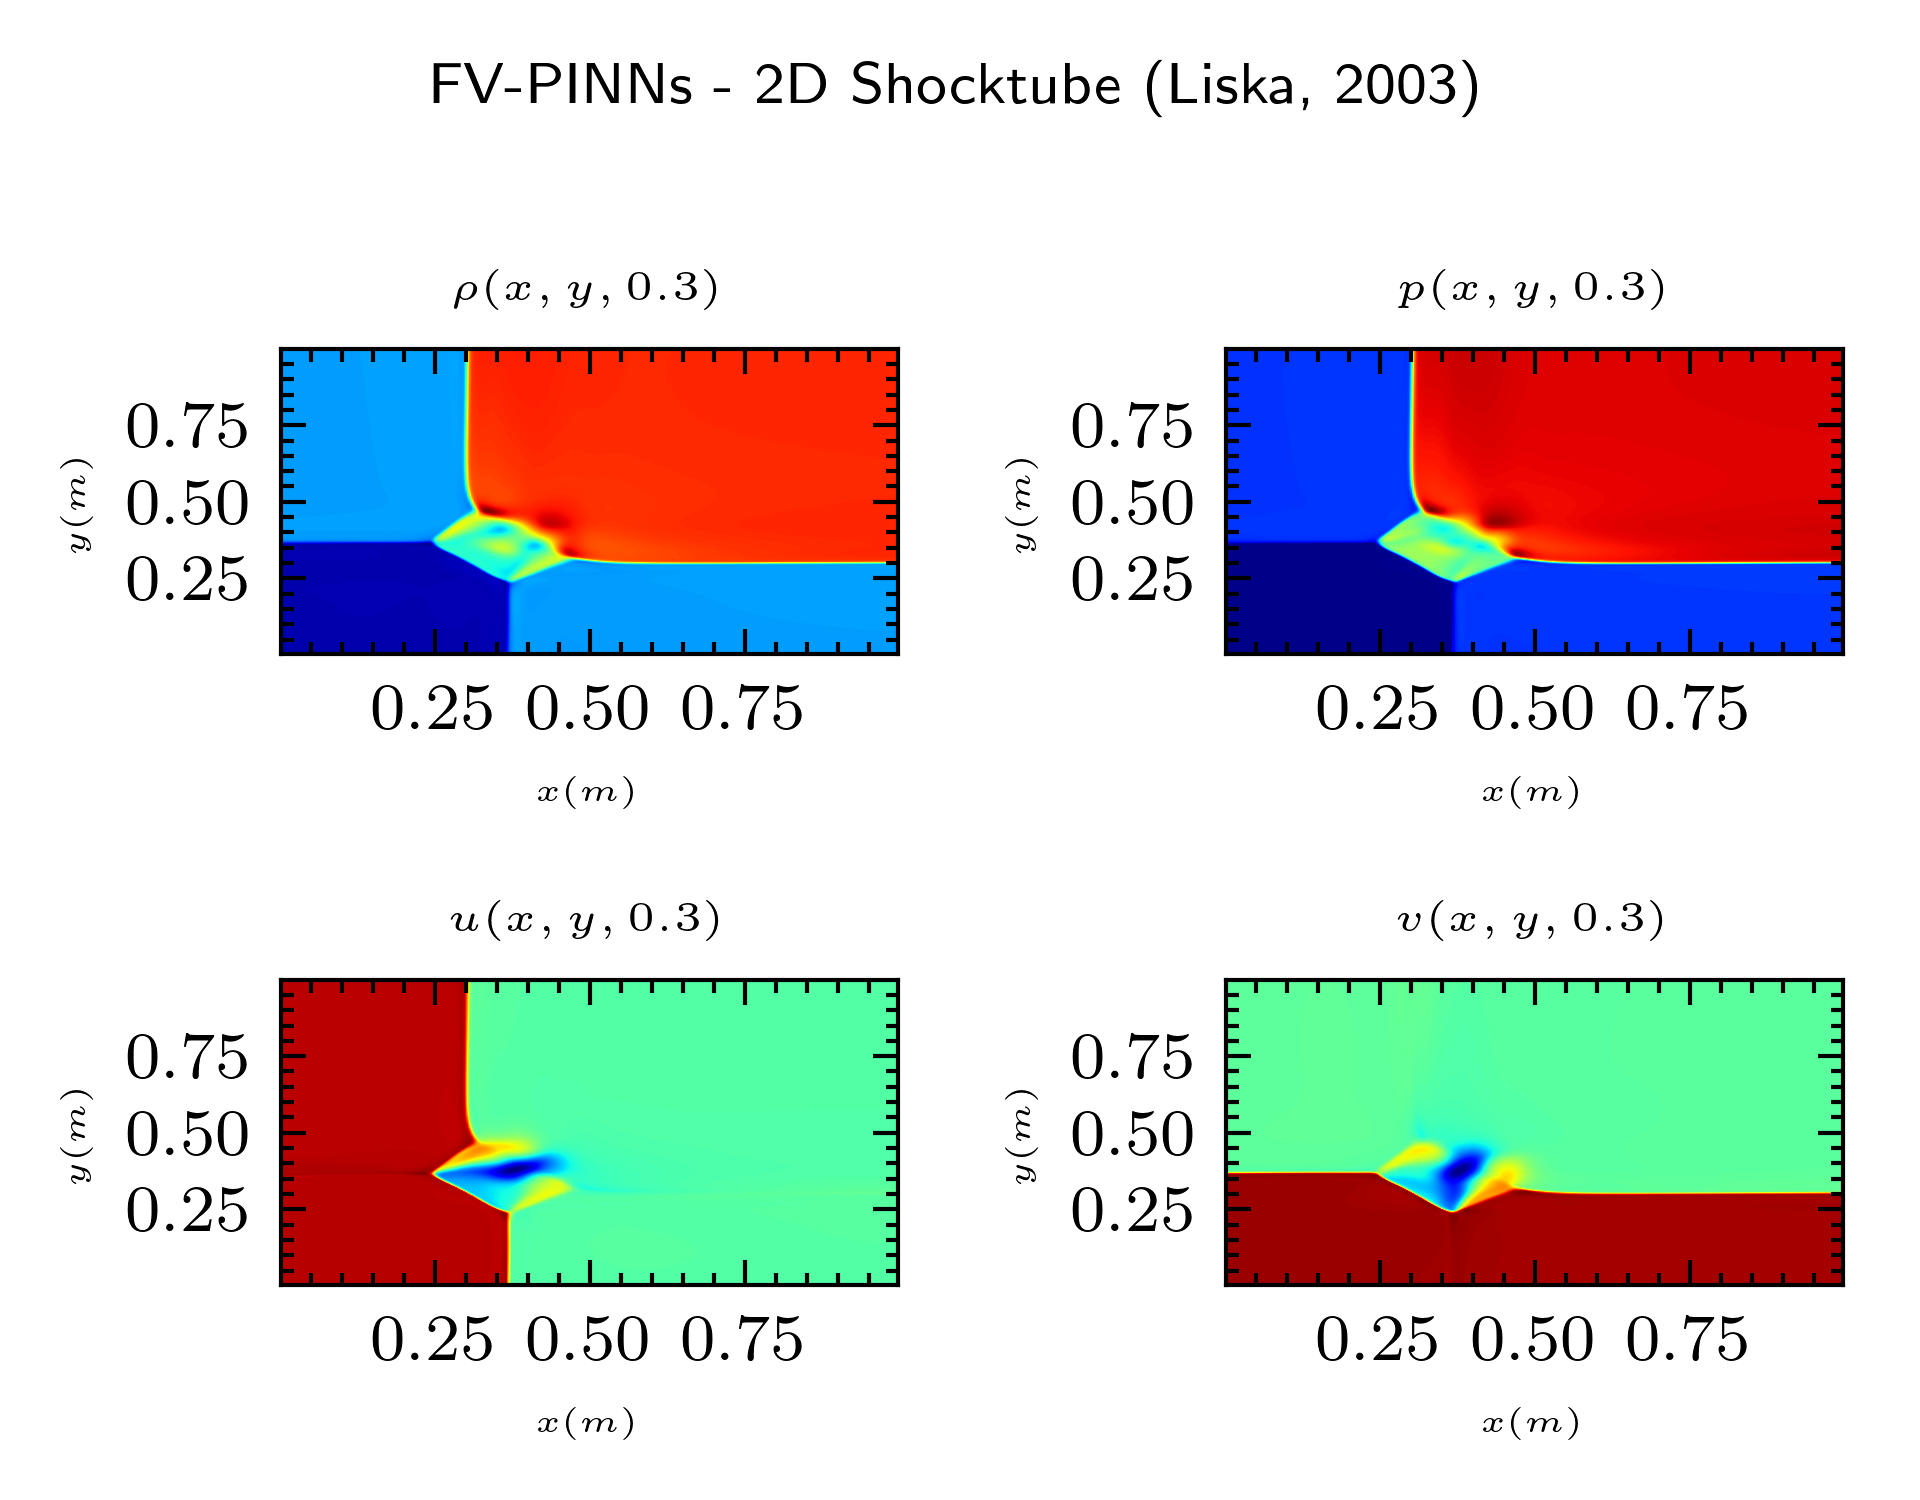

In [33]:
with plt.style.context(['science','ieee']):
    fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(nrows=2, ncols=2)
    ax1.contourf(x_new, y_new, r, 1000,cmap='jet')
    ax2.contourf(x_new, y_new, p, 1000,cmap='jet',extend='both')
    ax3.contourf(x_new, y_new, u, 1000,cmap='jet',extend='both')
    ax4.contourf(x_new, y_new, v, 1000,cmap='jet',extend='both')


    ax1.set_xlabel(r'$x(m)$', fontsize=4)
    ax1.set_ylabel(r'$y(m)$', fontsize=4)
    ax1.set_title(r'$\rho(x,y,0.3)$', fontsize=5)

    ax2.set_xlabel(r'$x(m)$', fontsize=4)
    ax2.set_ylabel(r'$y(m)$', fontsize=4)
    ax2.set_title(r'$p(x,y,0.3)$', fontsize=5)

    ax3.set_xlabel(r'$x(m)$', fontsize=4)
    ax3.set_ylabel(r'$y(m)$', fontsize=4)
    ax3.set_title(r'$u(x,y,0.3)$', fontsize=5)

    ax4.set_xlabel(r'$x(m)$', fontsize=4)
    ax4.set_ylabel(r'$y(m)$', fontsize=4)
    ax4.set_title(r'$v(x,y,0.3)$', fontsize=5)
fig.suptitle(r'FV-PINNs - 2D Shocktube (Liska, 2003)', fontsize=7)
plt.tight_layout()